# Данные

Были найдены данные DeepRockSR-2D из статьи **Rock CT Image Super-Resolution Using Residual Dual-Channel Attention Generative Adversarial Network, Liqun et al (2022)**. Они содержат 2D срезы карбонатов, угля и песчаников. Данные распределены по папкам с разными суффиксами:
* Суффиксы HR и LR означают качество изображений. 
* Суффиксы 2X и 4X означают размер downsampled LR из HR. Только LR обладают этими суффиксами. Размер HR - 500x500. Downsampling проводился с помощью функций imresize и imresize3 в matlab: 2X - понижение до 250x250, 4X - до 125x125.
* Суффиксы default и unknown означают настройки функций imresize: default - настройки по умолчанию, unknown - случайные. При default используется downsampling методом bicubic (бикубическая интерполяция).
* Суффиксы train, valid, test означают принадлежность той или иной выборке: train - обучающая, valid - валидационная, test - тестовая.

Префиксы coal, sandstone, carbonate означают принадлежность к типу породы: coal - уголь, sandstone - песчаник, carbonate - карбонатные породы.

Существует также и 3D датасет. Возможно его использование в будущем.

In [2]:
import pandas as pd
import os
from pathlib import Path

root_dir = Path("DeepRockSR-2D")

target_folders = {"carbonate2D_test_HR", "carbonate2D_train_HR", "carbonate2D_valid_HR",
                  "coal2D_test_HR", "coal2D_train_HR", "coal2D_valid_HR",
                  "sandstone2D_test_HR", "sandstone2D_train_HR", "sandstone2D_valid_HR",
                  "shuffled2D_test_HR", "shuffled2D_train_HR", "shuffled2D_valid_HR"}

image_extensions = {".png"}

records = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    folder_name = os.path.basename(dirpath)
    if folder_name in target_folders:
        count = sum(
            1 for f in filenames 
            if os.path.splitext(f)[1].lower() in image_extensions
        )
        records.append({"folder": folder_name, "count": count, "path": dirpath})

df = pd.DataFrame(records)
display(df)
print(df['count'].sum())

,folder,count,path
0,carbonate2D_test_HR,400,DeepRockSR-2D\carbonate2D\carbonate2D_test_HR
1,carbonate2D_train_HR,3200,DeepRockSR-2D\carbonate2D\carbonate2D_train_HR
2,carbonate2D_valid_HR,400,DeepRockSR-2D\carbonate2D\carbonate2D_valid_HR
3,coal2D_test_HR,400,DeepRockSR-2D\coal2D\coal2D_test_HR
4,coal2D_train_HR,3200,DeepRockSR-2D\coal2D\coal2D_train_HR
5,coal2D_valid_HR,400,DeepRockSR-2D\coal2D\coal2D_valid_HR
6,sandstone2D_test_HR,400,DeepRockSR-2D\sandstone2D\sandstone2D_test_HR
7,sandstone2D_train_HR,3200,DeepRockSR-2D\sandstone2D\sandstone2D_train_HR
8,sandstone2D_valid_HR,400,DeepRockSR-2D\sandstone2D\sandstone2D_valid_HR
9,shuffled2D_test_HR,1200,DeepRockSR-2D\shuffled2D\shuffled2D_test_HR


24000


Итого 24000 HR изображений. Взглянем на некоторые из них.

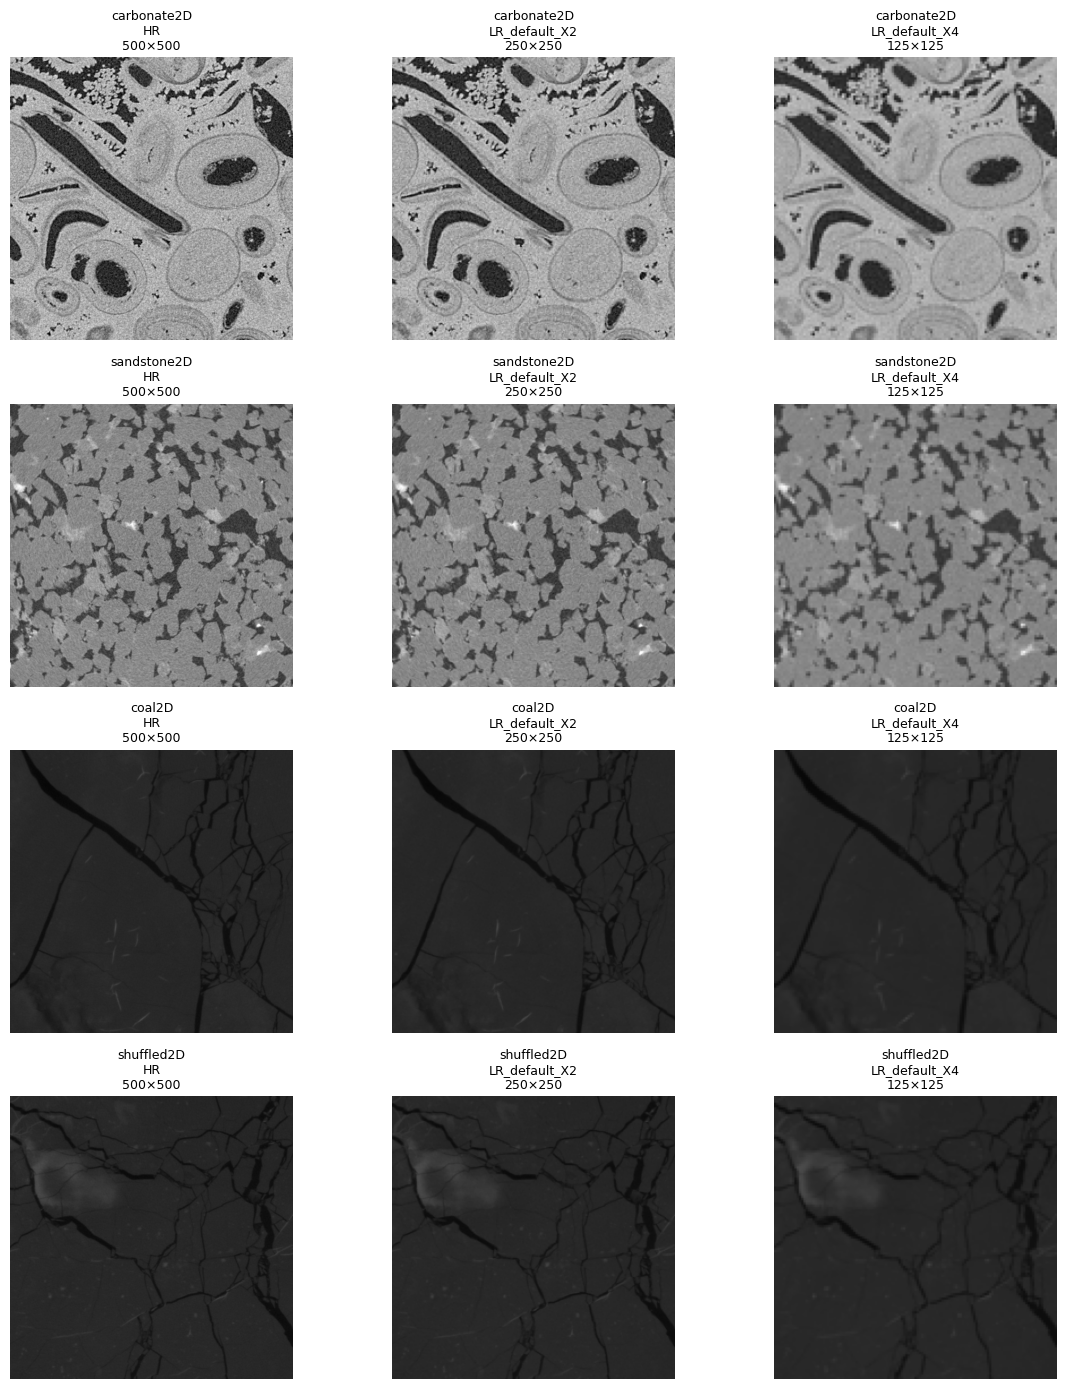

In [3]:
from pathlib import Path
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ROOT = Path(r"DeepRockSR-2D")
materials = ["carbonate2D", "sandstone2D", "coal2D", "shuffled2D"]
preferred_scale_order = ["HR", "LR_default_X2", "LR_default_X4"]
image_extensions = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

def natural_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r'\d+|\D+', s)]

def list_image_files(folder: Path):
    if not folder.exists():
        return []
    files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in image_extensions]
    return sorted(files, key=lambda p: natural_key(p.name))

def find_scale_folders(material_dir: Path):
    scale_dirs = {}
    for d in material_dir.iterdir():
        if d.is_dir():
            name = d.name
            m = re.search(r"_train_(.+)$", name)
            if m:
                scale = m.group(1)
                scale_dirs[scale] = d
    return scale_dirs

def read_image_any(path: Path) -> np.ndarray:
    img = Image.open(path)
    arr = np.array(img)
    return arr

def show_first_images_for_material(material: str, ax_row, available_scales, scale_to_dir):
    for j, scale in enumerate(available_scales):
        folder = scale_to_dir[scale]
        files = list_image_files(folder)
        ax = ax_row[j]
        ax.axis('off')

        if not files:
            ax.set_title(f"{material}\n{scale}\n(no images)", fontsize=9)
            continue

        first_img = read_image_any(files[0])

        # Определяем размер
        if first_img.ndim == 2:
            h, w = first_img.shape
            ax.imshow(first_img, cmap='gray')
        else:
            h, w = first_img.shape[:2]
            if first_img.ndim == 3 and first_img.shape[-1] == 4:
                first_img = first_img[..., :3]
            ax.imshow(first_img)

        ax.set_title(f"{material}\n{scale}\n{w}×{h}", fontsize=9)

rows_info = []
all_scales_seen = set()
per_material_scales = {}
per_material_dirs = {}

for mat in materials:
    mat_dir = ROOT / mat
    scale_dirs = find_scale_folders(mat_dir)
    per_material_dirs[mat] = scale_dirs
    per_material_scales[mat] = sorted(
        scale_dirs.keys(),
        key=lambda s: (preferred_scale_order.index(s) if s in preferred_scale_order else 999, s)
    )
    all_scales_seen.update(scale_dirs.keys())

ordered_scales = [s for s in preferred_scale_order if s in all_scales_seen]
ordered_scales += sorted(all_scales_seen - set(ordered_scales))

if not ordered_scales:
    raise RuntimeError(
        "Не найдено ни одной папки *_train_* с изображениями. "
        f"Проверьте структуру директорий внутри {ROOT}"
    )

n_rows = len(materials)
n_cols = len(ordered_scales)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), squeeze=False)

for i, mat in enumerate(materials):
    available_scales = [s for s in ordered_scales if s in per_material_scales[mat]]
    for j, scale in enumerate(ordered_scales):
        ax = axes[i, j]
        if scale not in per_material_scales[mat]:
            ax.axis('off')
            ax.set_title(f"{mat}\n{scale}\n(N/A)", fontsize=9)

    show_first_images_for_material(
        material=mat,
        ax_row=axes[i, :],
        available_scales=available_scales,
        scale_to_dir=per_material_dirs[mat]
    )

plt.tight_layout()
plt.show()

Проверим случайное изображение:

In [6]:
img = Image.open("DeepRockSR-2D/shuffled2D/shuffled2D_test_HR/10801.png")

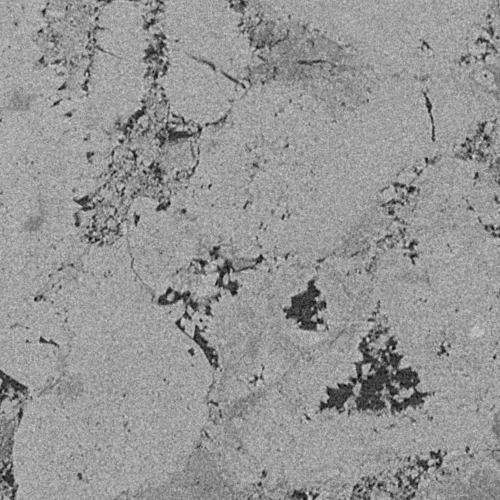

In [7]:
img

In [8]:
img.mode

'RGB'

Изображение в формате RGB, значит, в будущем стоит перевести в grayscale.

In [11]:
img = Image.open("MRCCM2D/HR_train/block_ILS1_z0022_g0022.tiff")

In [12]:
img

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=1520x1520>

In [10]:
img.mode

'F'